In [131]:
__author__ = "Victor Xu"
__email__ = "victor.c.xu@gmail.com"
__website__ = "victorxu.me"

__copyright__ = "Copyright 2019, Victor Xu"

In [132]:
import re
import pandas as pd
import numpy as np
import warnings

from src.espn_scraper import espn_player_scraper
from src.player_stat import get_player_stat, NoDataError

from sqlalchemy import create_engine
from tqdm import tqdm_notebook
from nba_py import player
from time import sleep
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns

## EDA

The goal of the EDA is to explore the structure of the data and build intuition around factors that influence player position labels.

In [136]:
engine = create_engine("sqlite:///db/nba.db", echo=False)
with engine.connect() as conn:
    data = pd.read_sql('player_stats', conn, index_col='nba_id')
    position = pd.read_sql('players', conn, index_col='nba_id')

In [139]:
data.head()

,shot_res,shot_in_paint,shot_mid_range,shot_lcorner_3,shot_rcorner_3,shot_above_3,fga,block_res,block_in_paint,block_mid_range,block_lcorner_3,block_rcorner_3,block_above_3,blka,oreb,dreb,ast,stl,min,espn_position
nba_id,,,,,,,,,,,,,,,,,,,,
101106,0.666666,0.277778,0.055556,0.000000,0.000000,0.000000,36,0.000000,0.999990,0.000000,0.0,0.000000,0.000000,1,10.1,26.9,7.2,2.0,350.758333,C
101107,0.188940,0.173579,0.052227,0.132104,0.062980,0.390169,651,0.619047,0.238095,0.000000,0.0,0.047619,0.095238,21,3.5,14.5,4.4,2.9,4139.115000,PF
101108,0.100418,0.211994,0.199442,0.030683,0.051604,0.405858,717,0.533333,0.333333,0.066667,0.0,0.000000,0.066667,15,1.9,13.1,24.1,5.4,3703.331667,PG
101108,0.100418,0.211994,0.199442,0.030683,0.051604,0.405858,717,0.533333,0.333333,0.066667,0.0,0.000000,0.066667,15,1.9,13.1,24.1,5.4,3703.331667,PG
101109,0.134328,0.179104,0.238806,0.037313,0.044776,0.365672,134,0.333332,0.333332,0.333332,0.0,0.000000,0.000000,3,1.4,8.4,13.7,3.0,1744.088333,PG


In [140]:
data.shape

(638, 20)

### Exploring Potential Structure in the Data

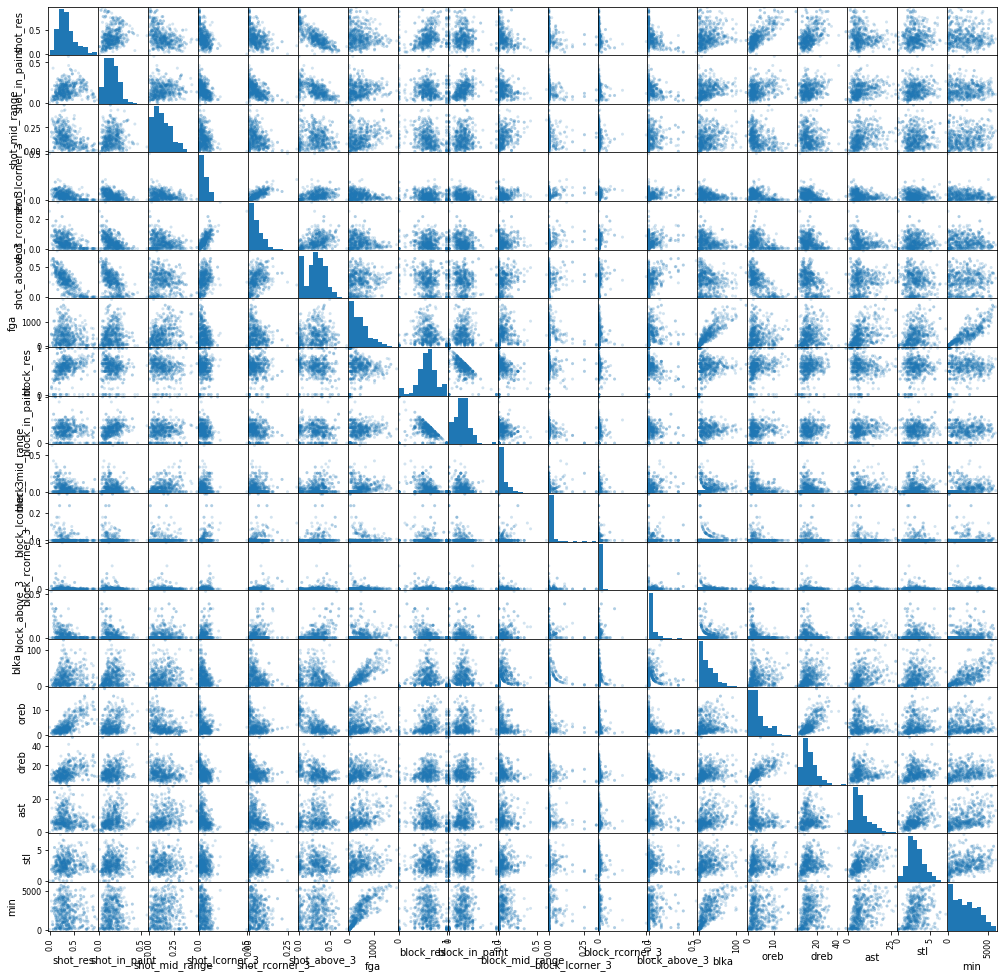

In [142]:
pd.plotting.scatter_matrix(data, alpha = 0.2, figsize=(17,17));

The scatterplot matrix suggests the following, which should be taken into account when modeling
- Many features have outliers
- Many features such as block_mid_range, block_lcorner_3 have a significant number of 0s. This is because blocks are inherently rare in the NBA.
- Features mostly follow either skewed normal, or exponential distribution

#### Feature summary

In [143]:
data.describe()

,shot_res,shot_in_paint,shot_mid_range,shot_lcorner_3,shot_rcorner_3,shot_above_3,fga,block_res,block_in_paint,block_mid_range,block_lcorner_3,block_rcorner_3,block_above_3,blka,oreb,dreb,ast,stl,min
count,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.00000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000,638.000000
mean,0.350014,0.155130,0.135860,0.048396,0.045812,0.264788,450.463950,0.589723,0.276288,0.053882,0.011214,0.01260,0.034347,24.974922,3.838871,12.682915,7.886050,2.728840,2201.008952
std,0.182000,0.080930,0.090683,0.042962,0.040982,0.158448,365.326006,0.203847,0.167764,0.074062,0.039317,0.05629,0.066060,22.212249,3.177797,6.579854,5.102384,1.253485,1520.656774
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.700000,0.000000,0.000000,15.716667
25%,0.222346,0.094595,0.063818,0.017544,0.013683,0.161090,158.000000,0.499999,0.176470,0.000000,0.000000,0.00000,0.000000,7.000000,1.600000,7.900000,4.400000,1.900000,916.472083
50%,0.314395,0.142495,0.123088,0.043265,0.037538,0.271270,380.000000,0.600000,0.276820,0.031250,0.000000,0.00000,0.000000,19.000000,2.700000,11.200000,6.300000,2.600000,2102.433333
75%,0.435190,0.211180,0.194932,0.072101,0.068815,0.378945,654.000000,0.698912,0.363636,0.078947,0.000000,0.00000,0.047078,36.000000,5.000000,16.100000,10.200000,3.400000,3333.282083
max,0.955326,0.575163,0.485294,0.499999,0.310345,0.769230,1908.000000,1.000000,0.999995,0.624999,0.333332,0.99999,0.533333,126.000000,18.600000,48.300000,27.900000,7.500000,6004.353333


#### Check class imbalance (player position label)

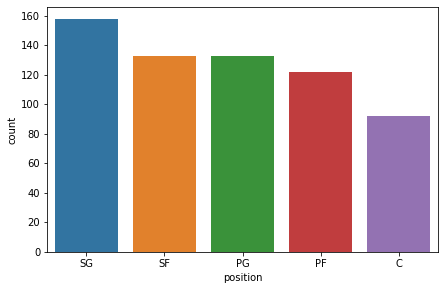

In [144]:
label_distribution_df = pd.DataFrame(data.espn_position.value_counts()).reset_index()
label_distribution_df.columns = ['position', 'count']

plt.figure(figsize = (7, 4.5))
sns.barplot(x='position', y='count', data=label_distribution_df);

Evidently, we have slight class imbalances. This will be addressed during the modeling process.

#### Shot and block attemps are mostly uniform across positions

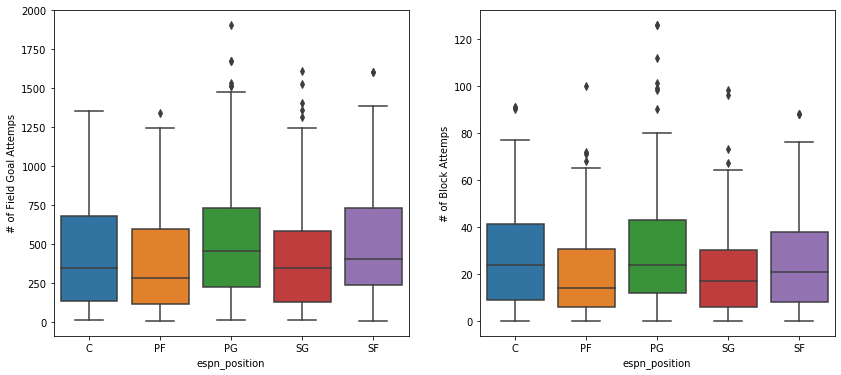

In [145]:
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(x='espn_position', y='fga', data=data)
plt.ylabel("# of Field Goal Attemps")

plt.subplot(1,2,2)
sns.boxplot(x='espn_position', y='blka', data=data)
plt.ylabel("# of Block Attemps");

#### Centers and Power Forwards are great rebounders

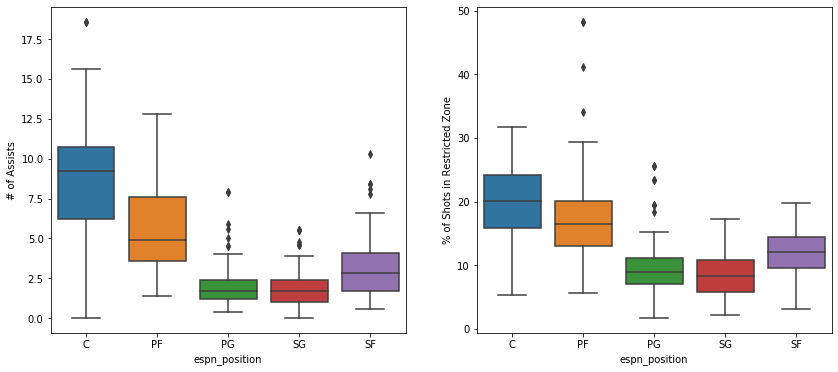

In [146]:
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(x='espn_position', y='oreb', data=data)
plt.ylabel("# of Assists")

plt.subplot(1,2,2)
sns.boxplot(x='espn_position', y='dreb', data=data)
plt.ylabel("% of Shots in Restricted Zone");

#### Point Guards outperform in both assists and steals

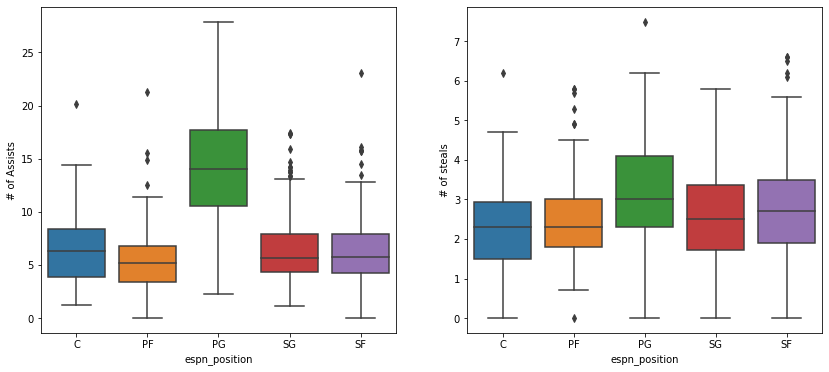

In [147]:
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(x='espn_position', y='ast', data=data)
plt.ylabel("# of Assists")

plt.subplot(1,2,2)
sns.boxplot(x='espn_position', y='stl', data=data)
plt.ylabel("# of steals");

#### Centers almost never take corner shots while Guards prefers the mid range

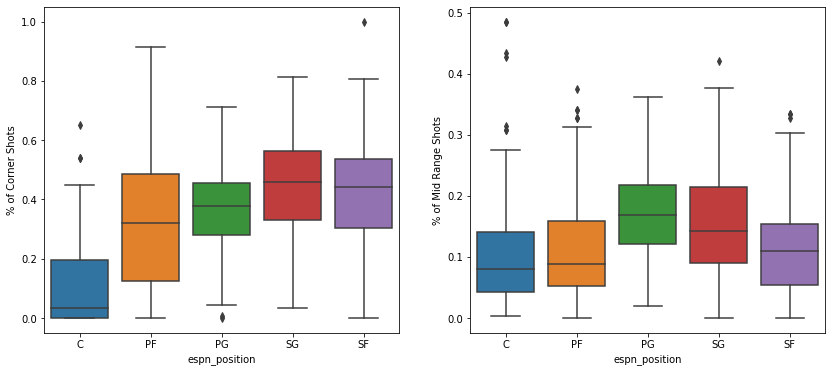

In [148]:
data_eda = data.copy() #shot_mid_range
data_eda['corner_shots'] = data_eda['shot_lcorner_3'] + data_eda['shot_rcorner_3'] + data_eda['shot_above_3']

plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(x='espn_position', y='corner_shots', data=data_eda)
plt.ylabel("% of Corner Shots")

plt.subplot(1,2,2)
sns.boxplot(x='espn_position', y='shot_mid_range', data=data_eda)
plt.ylabel("% of Mid Range Shots");

#### About 20% of the players have less than 100 shot attempts
The dataset is made up of 2 types of nba stats, shooting and blocking. As such, if a player has not attempted many shots or blocks, then predictions of his position will suffer from high variance. In other words, dropping players who havn't played enough should increase prediction accuracy and decrease model variance.

Let's explore a bit deeper on the distribution of shot attempts.

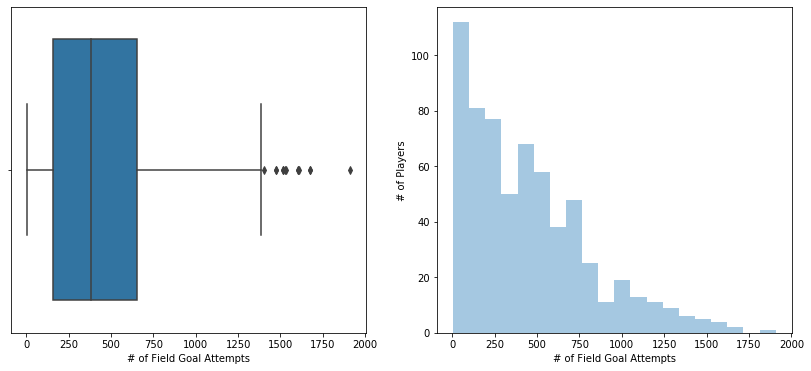

In [149]:
plt.figure(figsize = (14, 6))
plt.subplot(1,2,1)
sns.boxplot(data.fga)
plt.xlabel("# of Field Goal Attempts")

plt.subplot(1,2,2)
sns.distplot(data.fga, bins=20, kde=False)
plt.xlabel("# of Field Goal Attempts")
plt.ylabel("# of Players");